# Predicción de pedidos de taxi para la compañia Sweet Lift Taxi

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora.

## Introducción <a id='intro'></a>
**Propósito del proyecto**
    
   - Predecir la cantidad de pedidos de taxis para la próxima hora.

### Objetivos:
1. - Encontrar una métrica RECM en el conjunto de prueba menor a 48;
2. - Entrenar diferentes modelos con diferentes hiperparámetros;
3. - Probar los datos usando la muestra de prueba.

[Volver a Contenidos](#back)

## Inicialización <a id='inicializacion'></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

import xgboost as xgb
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import lightgbm as lgbm

## Cargando los datos <a id='cargando_datos'></a>

In [2]:
# leyendo el archivo y almacenándolo en df
df = pd.read_csv('/datasets/taxi.csv')

## Explorando los datos <a id='explorando_datos_iniciales'></a>

**Descripción de datos**

In [3]:
df.shape

(26496, 2)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [5]:
df.describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99])

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
95%,31.000000
99%,43.000000
max,119.000000


In [6]:
df.describe(exclude=['int', 'float'])

,datetime
count,26496
unique,26496
top,2018-07-10 07:50:00
freq,1


In [7]:
# Imprime una muestra de los datos
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


**Valores ausentes**

In [8]:
df.isna().sum().sort_values(ascending=False)

datetime      0
num_orders    0
dtype: int64

**Valores duplicados**

In [9]:
len(df.drop_duplicates()) == len(df)

True

**Conclusión intermedia**
 - El DataFrame **df** tiene 26.496 filas y 2 columnas. Sin valores ausentes, ni
    valores duplicados.

    
[Volver a Contenidos](#back)

## Análisis

In [10]:
# Cambiando el tipo de datos y configurando el índice
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [11]:
# Verificando que la fecha y hora esten en orden cronológico
data = data.sort_index(ascending=True) # o .sort_index(inplace=True)
data.index.is_monotonic

True

In [12]:
# Información general sobre la tabla 
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [13]:
data.index

DatetimeIndex(['2018-03-01 00:00:00', '2018-03-01 00:10:00',
               '2018-03-01 00:20:00', '2018-03-01 00:30:00',
               '2018-03-01 00:40:00', '2018-03-01 00:50:00',
               '2018-03-01 01:00:00', '2018-03-01 01:10:00',
               '2018-03-01 01:20:00', '2018-03-01 01:30:00',
               ...
               '2018-08-31 22:20:00', '2018-08-31 22:30:00',
               '2018-08-31 22:40:00', '2018-08-31 22:50:00',
               '2018-08-31 23:00:00', '2018-08-31 23:10:00',
               '2018-08-31 23:20:00', '2018-08-31 23:30:00',
               '2018-08-31 23:40:00', '2018-08-31 23:50:00'],
              dtype='datetime64[ns]', name='datetime', length=26496, freq=None)

In [14]:
data_series = data["num_orders"]

In [15]:
data_series.head()

datetime
2018-03-01 00:00:00     9
2018-03-01 00:10:00    14
2018-03-01 00:20:00    28
2018-03-01 00:30:00    20
2018-03-01 00:40:00    32
Name: num_orders, dtype: int64

In [16]:
# Cambiando el intervalo y agrupando los valores
data_resampled = data_series.resample('1H').mean()
data_resampled.head()

datetime
2018-03-01 00:00:00    20.666667
2018-03-01 01:00:00    14.166667
2018-03-01 02:00:00    11.833333
2018-03-01 03:00:00    11.000000
2018-03-01 04:00:00     7.166667
Freq: H, Name: num_orders, dtype: float64

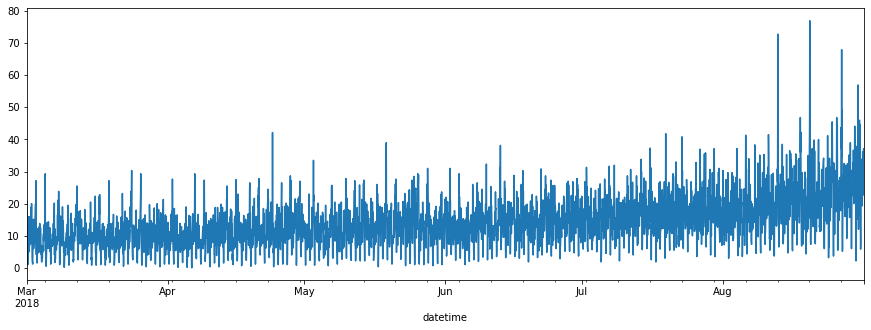

In [17]:
#Serie de tiempo
data_series.resample('1H').mean().plot(figsize=(15, 5))
plt.show()

 Se puede evidenciar que a partir del mes de junio aumentan los pedidos de taxi, estopodría deberse a epoca vacacional del país donde se han obtenido los datos.

**Seasonal_decompose**

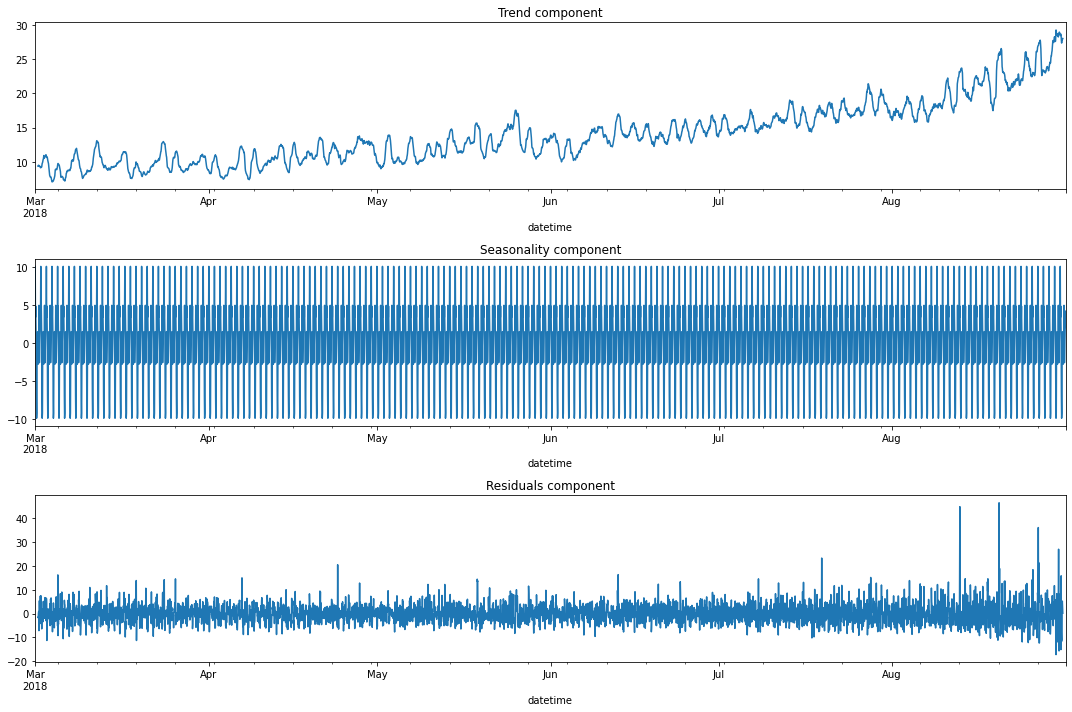

In [18]:
#Gráfico tendencia, estacionalidad y residuos.

data_resampled = data_series.resample("1H").mean()
decomposed_series = seasonal_decompose(data_resampled)

plt.figure(figsize=(15, 10))

plt.subplot(311)
# Para mostrar el gráfico de manera correcta, especifica su
# eje ax igual a plt.gca() (gca = obtener el eje actual)
decomposed_series.trend.plot(ax=plt.gca())
plt.title('Trend component')

plt.subplot(312)
decomposed_series.seasonal.plot(ax=plt.gca())
plt.title('Seasonality component')
plt.subplot(313)

decomposed_series.resid.plot(ax=plt.gca())
plt.title('Residuals component')
plt.tight_layout()

`Trend component` #Tendencia
Viendo el movimiento general (comportamiento de la serie), el aumento de pedidos de taxi se aprecia desde el mes de mayo, paulatinamente.

`Seasonality component` #Estacional
Se hara un zoon para aprediar mejor el patrón

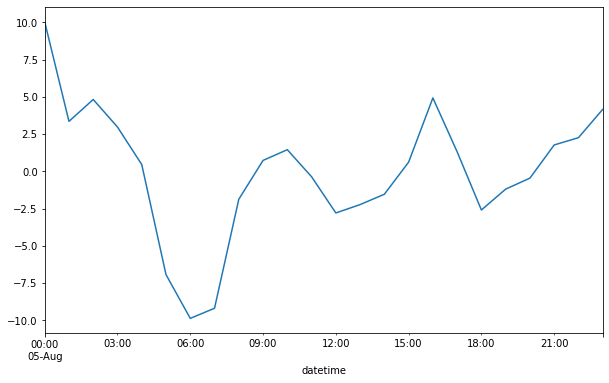

In [19]:
#Zoom de `Seasonality component` #Estacional
decomposed_series.seasonal["2018-08-05"].plot(figsize=(10, 6))
plt.show()

Se aprecia que cada cinco horas aumenta el pico del gráfico.

**Verificando igualdad de *combined_series* vs *data_resampled***

In [20]:
combined_series = decomposed_series.trend + decomposed_series.resid + decomposed_series.seasonal

combined_series.head(20)

datetime
2018-03-01 00:00:00          NaN
2018-03-01 01:00:00          NaN
2018-03-01 02:00:00          NaN
2018-03-01 03:00:00          NaN
2018-03-01 04:00:00          NaN
2018-03-01 05:00:00          NaN
2018-03-01 06:00:00          NaN
2018-03-01 07:00:00          NaN
2018-03-01 08:00:00          NaN
2018-03-01 09:00:00          NaN
2018-03-01 10:00:00          NaN
2018-03-01 11:00:00          NaN
2018-03-01 12:00:00     5.000000
2018-03-01 13:00:00     5.333333
2018-03-01 14:00:00     8.000000
2018-03-01 15:00:00    11.000000
2018-03-01 16:00:00     7.166667
2018-03-01 17:00:00     7.333333
2018-03-01 18:00:00    12.166667
2018-03-01 19:00:00     7.500000
Freq: H, dtype: float64

In [21]:
data_resampled.head(20)

datetime
2018-03-01 00:00:00    20.666667
2018-03-01 01:00:00    14.166667
2018-03-01 02:00:00    11.833333
2018-03-01 03:00:00    11.000000
2018-03-01 04:00:00     7.166667
2018-03-01 05:00:00     1.000000
2018-03-01 06:00:00     2.000000
2018-03-01 07:00:00     2.500000
2018-03-01 08:00:00     5.666667
2018-03-01 09:00:00    11.500000
2018-03-01 10:00:00    10.666667
2018-03-01 11:00:00    16.000000
2018-03-01 12:00:00     5.000000
2018-03-01 13:00:00     5.333333
2018-03-01 14:00:00     8.000000
2018-03-01 15:00:00    11.000000
2018-03-01 16:00:00     7.166667
2018-03-01 17:00:00     7.333333
2018-03-01 18:00:00    12.166667
2018-03-01 19:00:00     7.500000
Freq: H, Name: num_orders, dtype: float64

## Modelos

In [22]:
#Construcción de características

def make_features(df, lag_size=5, rolling_size=5):

  data_with_features = df.copy().to_frame()

  for i in range(lag_size):
    data_with_features[f"Número de orden {str(i+1)}"] = data_with_features["num_orders"].shift(i+1)

  data_with_features["rolling_mean"] = data_with_features["num_orders"].shift(1).rolling(rolling_size).mean()
  data_with_features["rolling_std"] = data_with_features["num_orders"].shift(1).rolling(rolling_size).std()
  data_with_features["rolling_min"] = data_with_features["num_orders"].shift(1).rolling(rolling_size).min()
  data_with_features["rolling_max"] = data_with_features["num_orders"].shift(1).rolling(rolling_size).max()

  return data_with_features

In [23]:
df_with_features = make_features(data_resampled, lag_size=5, rolling_size=5)
df_with_features.dropna(inplace=True)
# equivalente a: df_with_features = df_with_features.dropna()

df_with_features.head(10)

,num_orders,Número de orden 1,Número de orden 2,Número de orden 3,Número de orden 4,Número de orden 5,rolling_mean,rolling_std,rolling_min,rolling_max
datetime,,,,,,,,,,
2018-03-01 05:00:00,1.000000,7.166667,11.000000,11.833333,14.166667,20.666667,12.966667,4.988041,7.166667,20.666667
2018-03-01 06:00:00,2.000000,1.000000,7.166667,11.000000,11.833333,14.166667,9.033333,5.149703,1.000000,14.166667
2018-03-01 07:00:00,2.500000,2.000000,1.000000,7.166667,11.000000,11.833333,6.600000,4.989712,1.000000,11.833333
2018-03-01 08:00:00,5.666667,2.500000,2.000000,1.000000,7.166667,11.000000,4.733333,4.230511,1.000000,11.000000
2018-03-01 09:00:00,11.500000,5.666667,2.500000,2.000000,1.000000,7.166667,3.666667,2.622022,1.000000,7.166667
2018-03-01 10:00:00,10.666667,11.500000,5.666667,2.500000,2.000000,1.000000,4.533333,4.267773,1.000000,11.500000
2018-03-01 11:00:00,16.000000,10.666667,11.500000,5.666667,2.500000,2.000000,6.466667,4.452527,2.000000,11.500000
2018-03-01 12:00:00,5.000000,16.000000,10.666667,11.500000,5.666667,2.500000,9.266667,5.268618,2.500000,16.000000
2018-03-01 13:00:00,5.333333,5.000000,16.000000,10.666667,11.500000,5.666667,9.766667,4.533211,5.000000,16.000000


In [24]:
#Muestra de validación
full_train_set, test_set = train_test_split(df_with_features,
                                            shuffle=False,
                                            test_size=0.1)
#Muestra de prueba
train_set, valid_set = train_test_split(full_train_set,
                                        shuffle=False,
                                        test_size=0.1)

In [25]:
target = "num_orders"
features = [c for c in train_set.columns if c != target]

print(target, "\n", features)

num_orders 
 ['Número de orden 1', 'Número de orden 2', 'Número de orden 3', 'Número de orden 4', 'Número de orden 5', 'rolling_mean', 'rolling_std', 'rolling_min', 'rolling_max']


### Regresión líneal

In [26]:
#Entrenamiento del modelo
linear_model = LinearRegression()
linear_model.fit(full_train_set[features], full_train_set[target])

linear_model_preds = linear_model.predict(test_set[features])

In [27]:
print(f"""
Linear Model RECM: {round(mean_squared_error(test_set[target], linear_model_preds)**0.5, 2)}
""")


Linear Model RECM: 9.43



In [28]:
linear_model_preds.mean()

19.050055036793292

In [29]:
series_preds = pd.DataFrame(data={
    "prediction": linear_model_preds,
    "target": test_set[target],
}, index=test_set.index)

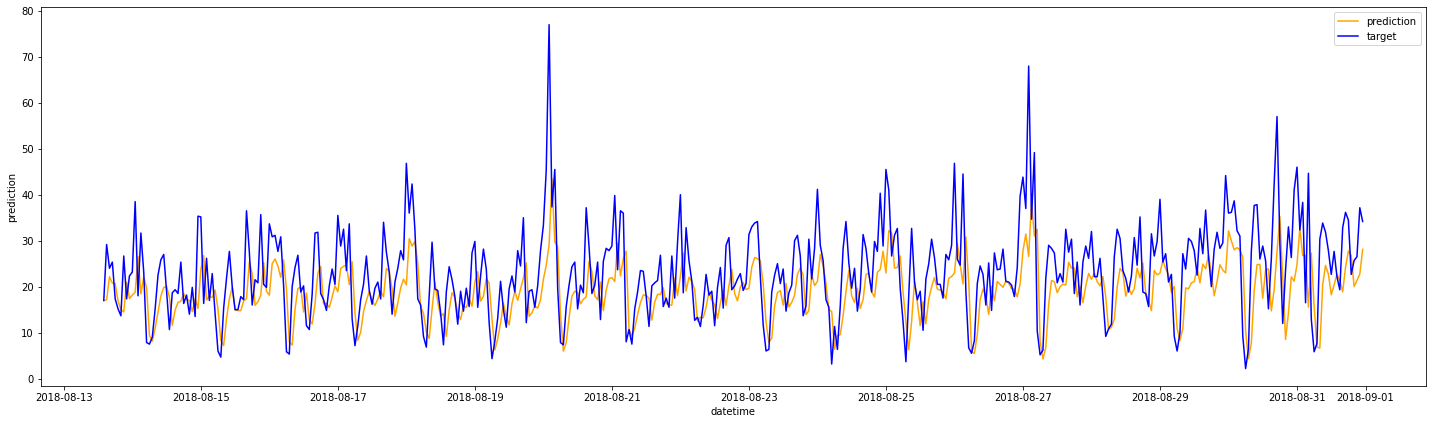

In [30]:
plt.figure(figsize=(20, 6))
sns.lineplot(data=series_preds, x=series_preds.index, y="prediction", label="prediction", color="orange")
sns.lineplot(data=series_preds, x=series_preds.index, y="target", label="target", color="blue")
plt.tight_layout()

In [31]:
#Desempeño a través del tiempo
series_preds["week"] = pd.to_datetime(series_preds.index)
series_preds["week"] = series_preds["week"].astype("datetime64[W]")

rmses = []
weeks = []

for week in series_preds["week"].unique():

  tmp_data = series_preds[series_preds["week"] == week]

  rmses.append(mean_squared_error(tmp_data["target"], tmp_data["prediction"])**0.5)
  weeks.append(week)

weekly_performance = pd.DataFrame(data={
    "week": weeks,
    "rmse": rmses
})

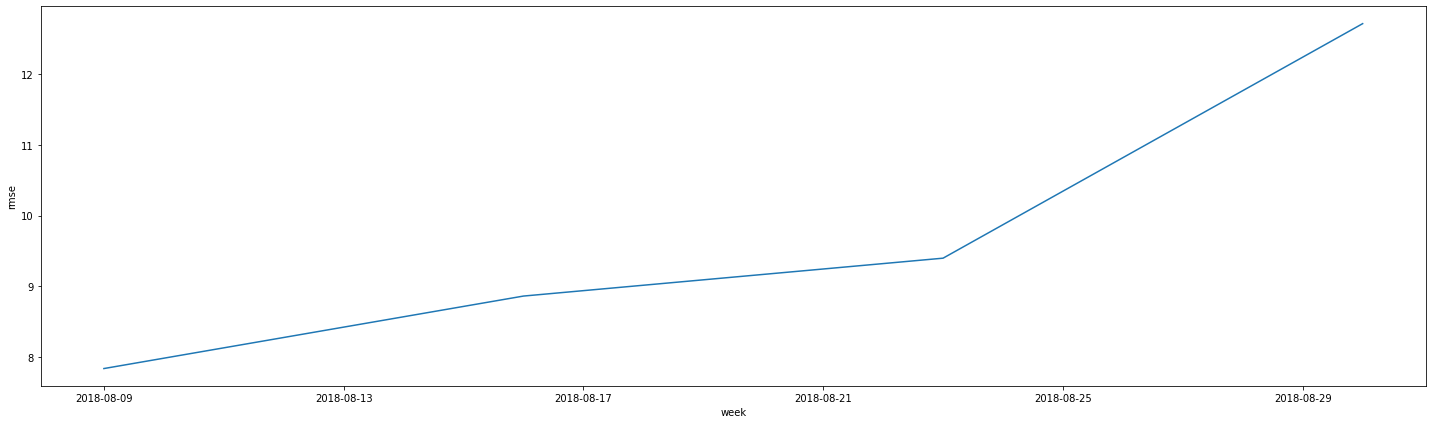

In [32]:
plt.figure(figsize=(20, 6))
sns.lineplot(data=weekly_performance, x="week", y="rmse")
plt.tight_layout()

### Random forest

In [33]:
random_forest_model = RandomForestRegressor()

In [34]:
#n_estimators
#max_depth

In [35]:
#hiperparámetros a buscar
distributions = dict(
    n_estimators=list(range(50, 75)),
    max_depth=list(range(3, 10))
)

rf_tuned = RandomizedSearchCV(random_forest_model, distributions, n_iter=5, cv=3, random_state=200)
rf_tuned.fit(full_train_set[features], full_train_set[target])

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=5,
                   param_distributions={'max_depth': [3, 4, 5, 6, 7, 8, 9],
                                        'n_estimators': [50, 51, 52, 53, 54, 55,
                                                         56, 57, 58, 59, 60, 61,
                                                         62, 63, 64, 65, 66, 67,
                                                         68, 69, 70, 71, 72, 73,
                                                         74]},
                   random_state=200)

In [36]:
rf_preds = rf_tuned.predict(test_set[features])

In [37]:
print(f"""
RF Moldel RECM: {round(mean_squared_error(test_set[target], rf_preds)**0.5, 2)}
""")


RF Moldel RECM: 10.37



In [38]:
rf_preds.mean()

18.397320020654334

In [39]:
series_preds_rf = pd.DataFrame(data={
    "prediction": rf_preds,
    "target": test_set[target],
}, index=test_set.index)

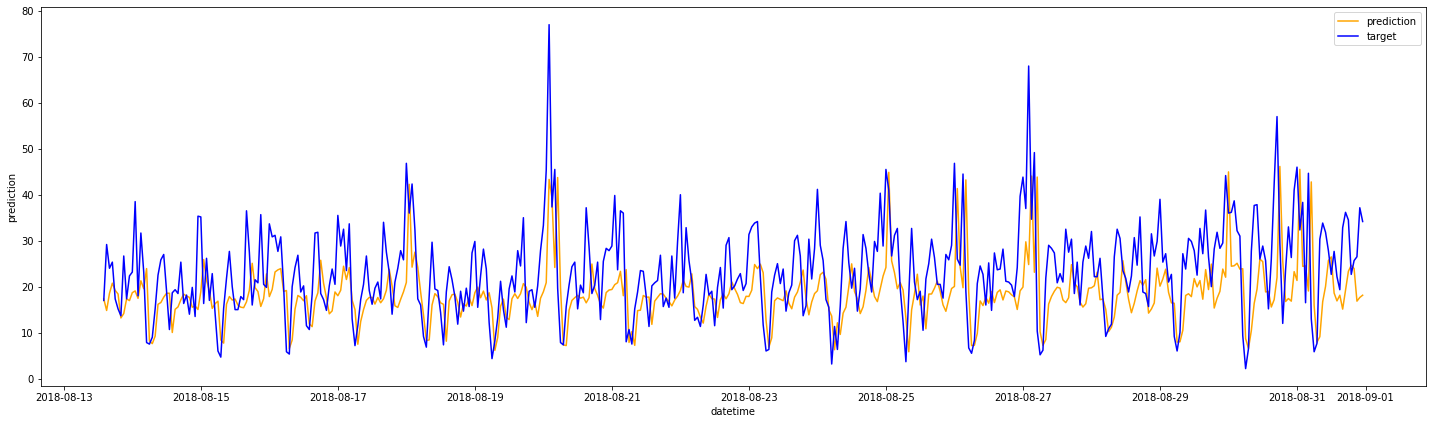

In [40]:
plt.figure(figsize=(20, 6))
sns.lineplot(data=series_preds_rf, x=series_preds_rf.index, y="prediction", label="prediction", color="orange")
sns.lineplot(data=series_preds_rf, x=series_preds_rf.index, y="target", label="target", color="blue")
plt.tight_layout()

In [41]:
#Desempeño a través del tiempo
series_preds_rf["week"] = pd.to_datetime(series_preds_rf.index)
series_preds_rf["week"] = series_preds_rf["week"].astype("datetime64[W]")

rmses = []
weeks = []

for week in series_preds_rf["week"].unique():

  tmp_data = series_preds_rf[series_preds_rf["week"] == week]

  rmses.append(mean_squared_error(tmp_data["target"], tmp_data["prediction"])**0.5)
  weeks.append(week)

weekly_performance_rf = pd.DataFrame(data={
    "week": weeks,
    "rmse": rmses
})

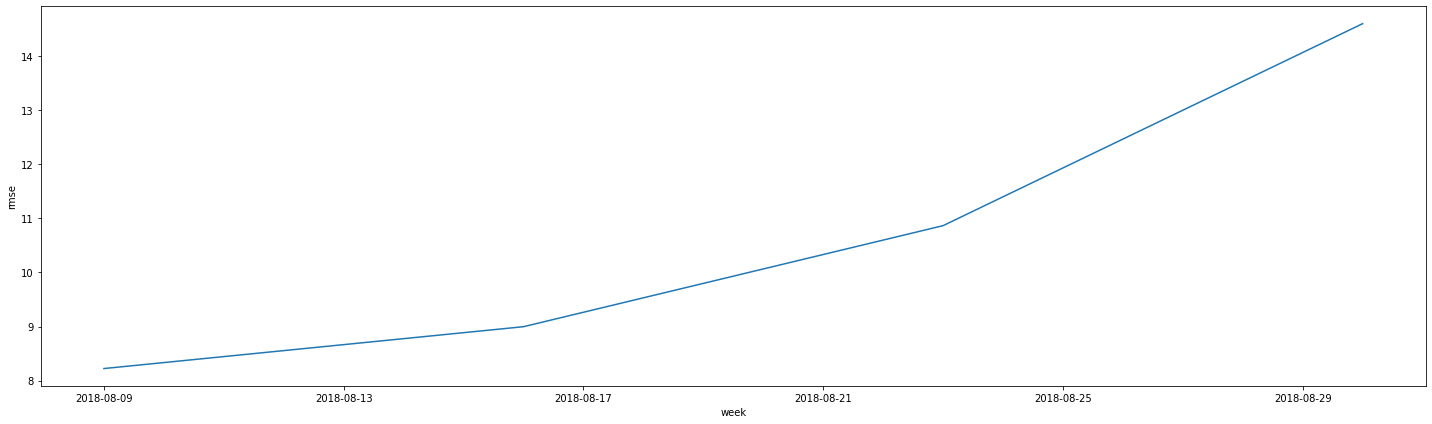

In [42]:
plt.figure(figsize=(20, 6))
sns.lineplot(data=weekly_performance_rf, x="week", y="rmse")
plt.tight_layout()

### LGBM

In [43]:
lgbm_model = lgbm.LGBMRegressor(
    learning_rate = 0.05,
    random_state = 200
)

#hiperparámetros a buscar
grid_params = {
    'max_depth': list(range(3, 10)),
    'objective': ["mean_squared_error", "mean_absolute_error"],
    'n_estimators': list(range(50, 100))
}

#modelling
lgbm_tuned = RandomizedSearchCV(lgbm_model, grid_params, cv= 3, n_jobs= -1, n_iter=5)

In [44]:
lgbm_tuned.fit(full_train_set[features], full_train_set[target])

RandomizedSearchCV(cv=3,
                   estimator=LGBMRegressor(learning_rate=0.05,
                                           random_state=200),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'max_depth': [3, 4, 5, 6, 7, 8, 9],
                                        'n_estimators': [50, 51, 52, 53, 54, 55,
                                                         56, 57, 58, 59, 60, 61,
                                                         62, 63, 64, 65, 66, 67,
                                                         68, 69, 70, 71, 72, 73,
                                                         74, 75, 76, 77, 78, 79, ...],
                                        'objective': ['mean_squared_error',
                                                      'mean_absolute_error']})

In [45]:
lgbm_preds = lgbm_tuned.predict(test_set[features])

In [46]:
print(f"""
LightGBM Moldel RECM: {round(mean_squared_error(test_set[target], lgbm_preds)**0.5, 2)}
""")


LightGBM Moldel RECM: 10.18



In [47]:
lgbm_preds.mean()

17.850008448949385

In [48]:
series_preds_lgbm = pd.DataFrame(data={
    "prediction": lgbm_preds,
    "target": test_set[target],
}, index=test_set.index)

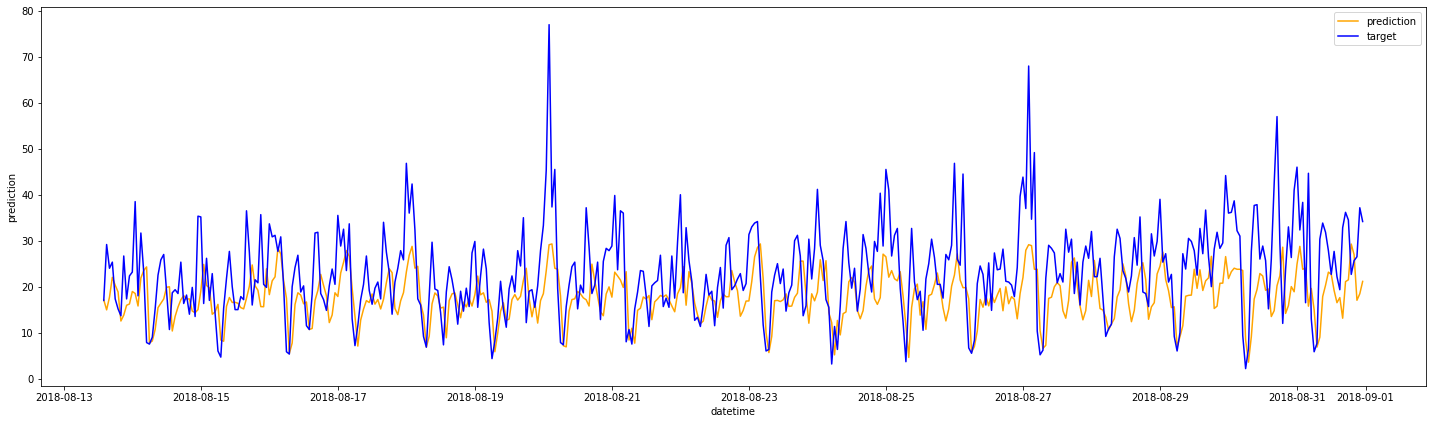

In [49]:
plt.figure(figsize=(20, 6))
sns.lineplot(data=series_preds_lgbm, x=series_preds_lgbm.index, y="prediction", label="prediction", color="orange")
sns.lineplot(data=series_preds_lgbm, x=series_preds_lgbm.index, y="target", label="target", color="blue")
plt.tight_layout()

In [50]:
#Desempeño a través del tiempo
series_preds_lgbm["week"] = pd.to_datetime(series_preds_lgbm.index)
series_preds_lgbm["week"] = series_preds_lgbm["week"].astype("datetime64[W]")

rmses = []
weeks = []

for week in series_preds_lgbm["week"].unique():

  tmp_data = series_preds_lgbm[series_preds_lgbm["week"] == week]

  rmses.append(mean_squared_error(tmp_data["target"], tmp_data["prediction"])**0.5)
  weeks.append(week)

weekly_performance_lgbm = pd.DataFrame(data={
    "week": weeks,
    "rmse": rmses
})

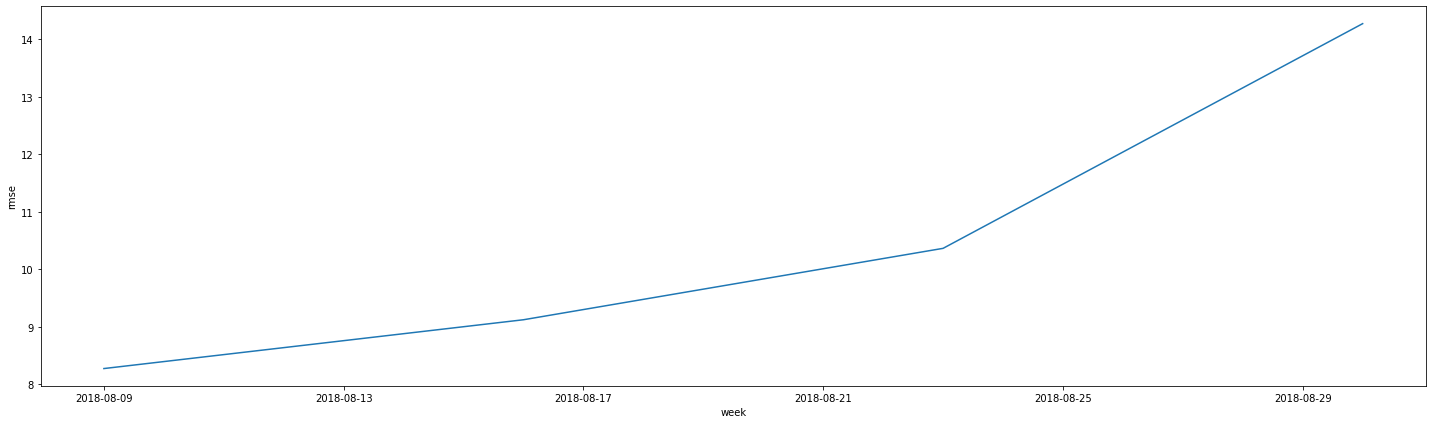

In [51]:
plt.figure(figsize=(20, 6))
sns.lineplot(data=weekly_performance_lgbm, x="week", y="rmse")
plt.tight_layout()

### CatBoost

In [52]:
CB_model = CatBoostRegressor(
    loss_function="RMSE",
    n_estimators=150,
    learning_rate=0.01,
    max_depth=5,
    random_seed=200
)

CB_model.fit(full_train_set[features], full_train_set[target], verbose=10)

CB_preds = CB_model.predict(test_set[features])

0:	learn: 6.4283200	total: 48.7ms	remaining: 7.25s
10:	learn: 6.2536926	total: 72.9ms	remaining: 922ms
20:	learn: 6.1032324	total: 97.9ms	remaining: 602ms
30:	learn: 5.9704628	total: 125ms	remaining: 481ms
40:	learn: 5.8575501	total: 150ms	remaining: 398ms
50:	learn: 5.7589718	total: 173ms	remaining: 337ms
60:	learn: 5.6734730	total: 199ms	remaining: 290ms
70:	learn: 5.6017201	total: 223ms	remaining: 248ms
80:	learn: 5.5354349	total: 247ms	remaining: 211ms
90:	learn: 5.4805032	total: 271ms	remaining: 176ms
100:	learn: 5.4306423	total: 295ms	remaining: 143ms
110:	learn: 5.3883795	total: 318ms	remaining: 112ms
120:	learn: 5.3507723	total: 342ms	remaining: 82ms
130:	learn: 5.3177980	total: 365ms	remaining: 53ms
140:	learn: 5.2887376	total: 389ms	remaining: 24.8ms
149:	learn: 5.2634076	total: 410ms	remaining: 0us


In [53]:
print(f"""
CatBoost Moldel RECM: {round(mean_squared_error(test_set[target], CB_preds)**0.5, 2)}
""")


CatBoost Moldel RECM: 11.2



In [54]:
CB_preds.mean()

16.335884900170587

In [55]:
series_preds_CB = pd.DataFrame(data={
    "prediction": CB_preds,
    "target": test_set[target],
}, index=test_set.index)

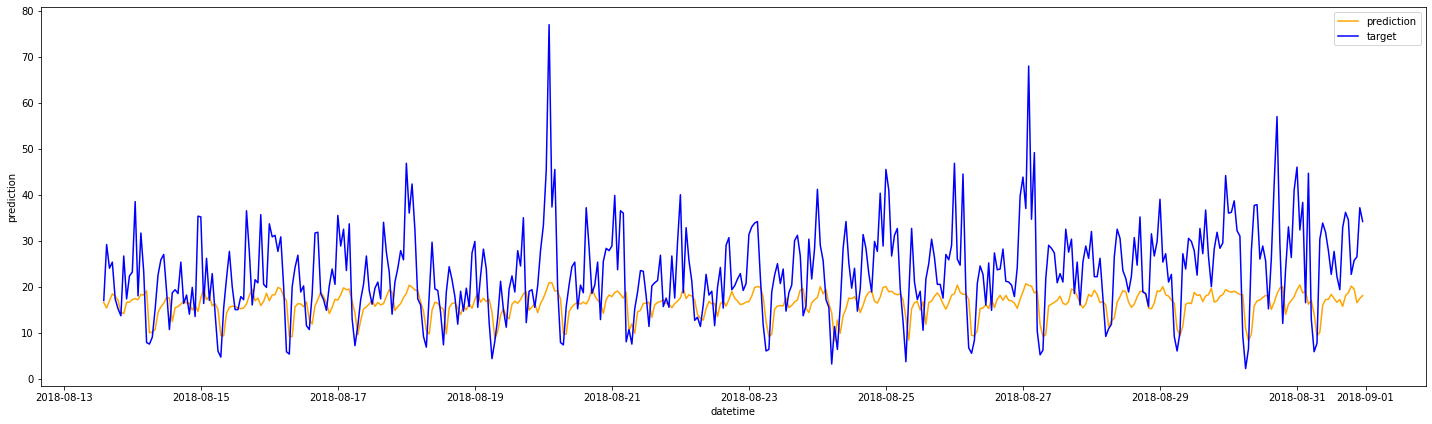

In [56]:
plt.figure(figsize=(20, 6))
sns.lineplot(data=series_preds_CB, x=series_preds_CB.index, y="prediction", label="prediction", color="orange")
sns.lineplot(data=series_preds_CB, x=series_preds_CB.index, y="target", label="target", color="blue")
plt.tight_layout()

In [57]:
#Desempeño a través del tiempo
series_preds_CB["week"] = pd.to_datetime(series_preds_CB.index)
series_preds_CB["week"] = series_preds_CB["week"].astype("datetime64[W]")

rmses = []
weeks = []

for week in series_preds_CB["week"].unique():

  tmp_data = series_preds_CB[series_preds_CB["week"] == week]

  rmses.append(mean_squared_error(tmp_data["target"], tmp_data["prediction"])**0.5)
  weeks.append(week)

weekly_performance_CB = pd.DataFrame(data={
    "week": weeks,
    "rmse": rmses
})

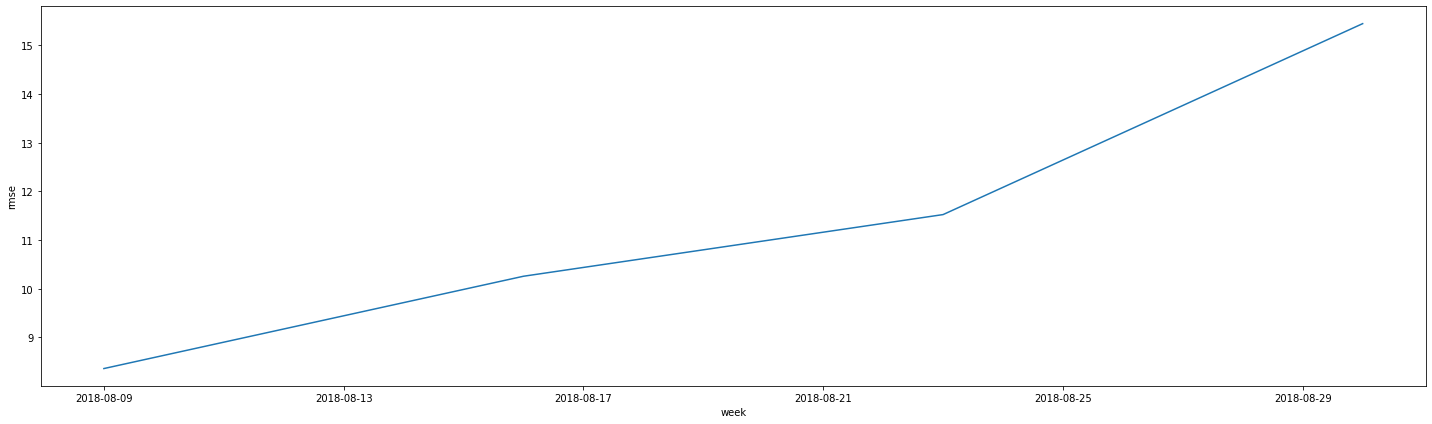

In [58]:
plt.figure(figsize=(20, 6))
sns.lineplot(data=weekly_performance_CB, x="week", y="rmse")
plt.tight_layout()

### XGBoost

In [59]:
XGB_model = XGBRegressor(
    loss_function="RMSE",
    n_estimators=150,
    learning_rate=0.01,
    max_depth=5,
    random_seed=200
)

XGB_model.fit(full_train_set[features], full_train_set[target])

XGB_preds = XGB_model.predict(test_set[features])

[21:54:12] WARNING: ../src/learner.cc:576: 
Parameters: { "loss_function", "random_seed" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [60]:
print(f"""
XGBoost Moldel RECM: {round(mean_squared_error(test_set[target], XGB_preds)**0.5, 2)}
""")


XGBoost Moldel RECM: 12.79



In [61]:
XGB_preds.mean()

13.936477

In [62]:
series_preds_XGB = pd.DataFrame(data={
    "prediction": XGB_preds,
    "target": test_set[target],
}, index=test_set.index)

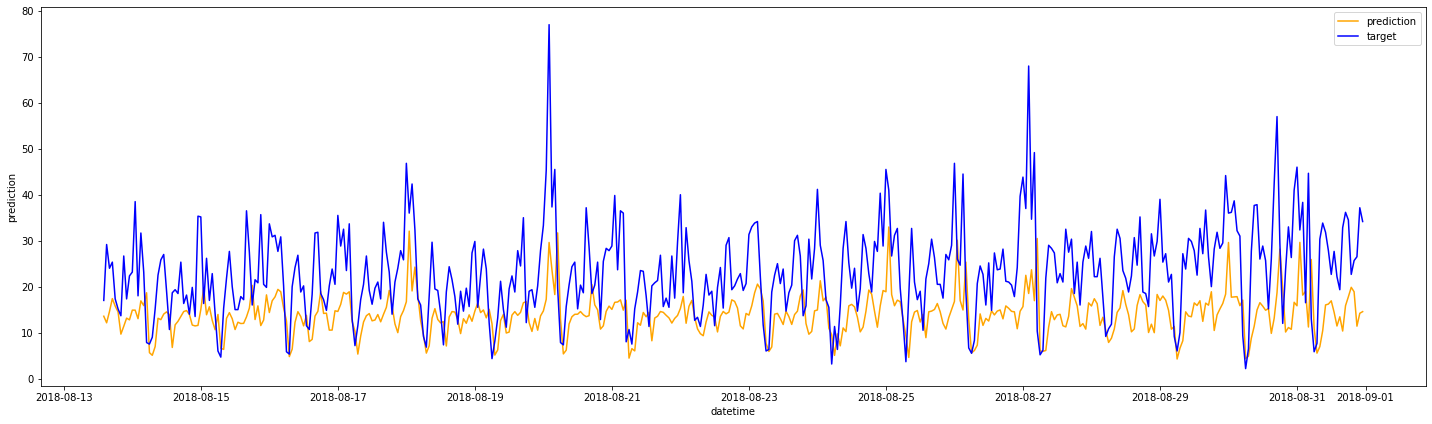

In [63]:
plt.figure(figsize=(20, 6))
sns.lineplot(data=series_preds_XGB, x=series_preds_CB.index, y="prediction", label="prediction", color="orange")
sns.lineplot(data=series_preds_XGB, x=series_preds_CB.index, y="target", label="target", color="blue")
plt.tight_layout()

In [64]:
#Desempeño a través del tiempo
series_preds_XGB["week"] = pd.to_datetime(series_preds_XGB.index)
series_preds_XGB["week"] = series_preds_XGB["week"].astype("datetime64[W]")

rmses = []
weeks = []

for week in series_preds_XGB["week"].unique():

  tmp_data = series_preds_XGB[series_preds_XGB["week"] == week]

  rmses.append(mean_squared_error(tmp_data["target"], tmp_data["prediction"])**0.5)
  weeks.append(week)

weekly_performance_XGB = pd.DataFrame(data={
    "week": weeks,
    "rmse": rmses
})

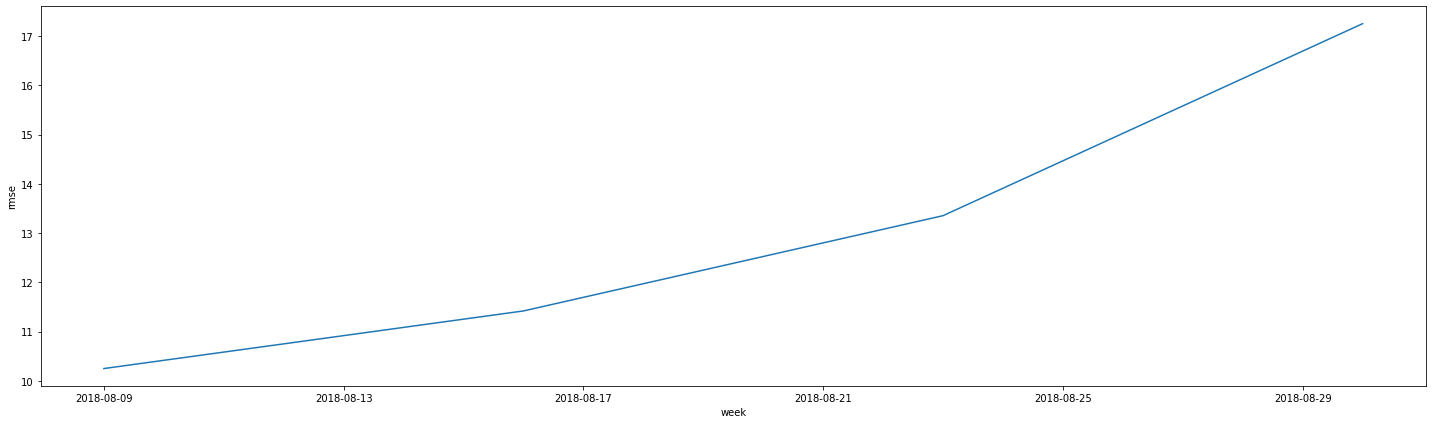

In [65]:
plt.figure(figsize=(20, 6))
sns.lineplot(data=weekly_performance_XGB, x="week", y="rmse")
plt.tight_layout()

## Conclusiones

Se realizó una exploración de datos donde se evidenció que el DataFrame df tiene 26.496 filas y 2 columnas. Sin valores ausentes, ni valores duplicados. Luego, se cambiaron los tipos de datos de *datetime* y se configuro el índice del DataFrame. Cambiando luego el intervalo a *1H*. Se realizaron los gráficos de tendencia, estacionalidad y residuos que nos permitió ver observar diferentes componentes de los datos, cómo el movimiento general de los datos, patrones y datos sin residuos. Se verificó la igualdad de combined_series vs data_resampled.

Se entrenaron modelos de Regresión líneal, Random Forest, LGBM, CatBoost y XGBoost. Donde con LGBM se obtuvo un menor RECM de 10.17. Se realizarón gráficos target vs prediction para cada modelo, donde se pudo observar como estaban predicciendo cada uno de ellos.

# Lista de revisión

- [x]  	
Jupyter Notebook está abierto.
- [x]  El código no tiene errores
- [x]  Las celdas con el código han sido colocadas en el orden de ejecución.
- [x]  Los datos han sido descargados y preparados.
- [x]  Se ha realizado el paso 2: los datos han sido analizados
- [x]  Se entrenó el modelo y se seleccionaron los hiperparámetros
- [x]  Se han evaluado los modelos. Se expuso una conclusión
- [x] La *RECM* para el conjunto de prueba no es más de 48